### Imports

In [30]:
from scipy.optimize import linprog
import numpy as np
import matplotlib.pyplot as plt
import intvalpy as ip

### Problem 1

Problem for linprog should be in the form:

$$
\begin{align} \min_{x} & \quad c^T x \\ \text{s.t.} 
& \quad A_{ub} x \leq b_{ub} \\ 
& \quad A_{eq} x = b_{eq} \\
& \quad l \leq x \leq u

\end{align}
$$

Where $c$, $A_{ub}$, $b_{ub}$, $A_{eq}$, $b_{eq}$ are (numpy) arrays.

In [31]:
# coefficients of linear objective function to be minimized
c = [-3, -2]
A = [[2, 1], 
     [1, 1],
     [1, 0]]
b_ub = [10, 8, 4]

# bounds on variables (x0, x1). By default, all variables are non-negative 
# (so this is redundant, but included for clarity)
x0_bounds = (0, None)
x1_bounds = (0, None)

Find solution

In [32]:
res = linprog(c, A_ub=A, b_ub=b_ub, bounds=[x0_bounds, x1_bounds])
print(res)

        message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: -18.0
              x: [ 2.000e+00  6.000e+00]
            nit: 2
          lower:  residual: [ 2.000e+00  6.000e+00]
                 marginals: [ 0.000e+00  0.000e+00]
          upper:  residual: [       inf        inf]
                 marginals: [ 0.000e+00  0.000e+00]
          eqlin:  residual: []
                 marginals: []
        ineqlin:  residual: [ 0.000e+00  0.000e+00  2.000e+00]
                 marginals: [-1.000e+00 -1.000e+00 -0.000e+00]
 mip_node_count: 0
 mip_dual_bound: 0.0
        mip_gap: 0.0


Visualize solution

Based on steps explained here: https://machinelearningmastery.com/visualization-for-function-optimization-in-python/

In [33]:
# objective function
def objective(x, c):
    return c[0] * x[0] + c[1] * x[1]

# define range for input
r_min, r_max = 0, 10

# sample input range uniformly at 0.1 increments
x0axis = np.arange(r_min, r_max, 0.01)
x1axis = np.arange(r_min, r_max, 0.01)

# create a mesh from the axis
x1, x2 = np.meshgrid(x0axis, x1axis)
x = np.stack((x1, x2), axis=0)

# compute targets
results = objective(x, c)

# create a mapping of some inputs to some results
for i in range(0, 20, 5):
    for j in range(0, 20, 5):
        print('x1=%.1f, x2=%.1f, f(x1,x2)=%.3f' % (x1[i,j], x2[i,j], results[i,j]))

x1=0.0, x2=0.0, f(x1,x2)=-0.000
x1=0.1, x2=0.0, f(x1,x2)=-0.150
x1=0.1, x2=0.0, f(x1,x2)=-0.300
x1=0.1, x2=0.0, f(x1,x2)=-0.450
x1=0.0, x2=0.1, f(x1,x2)=-0.100
x1=0.1, x2=0.1, f(x1,x2)=-0.250
x1=0.1, x2=0.1, f(x1,x2)=-0.400
x1=0.1, x2=0.1, f(x1,x2)=-0.550
x1=0.0, x2=0.1, f(x1,x2)=-0.200
x1=0.1, x2=0.1, f(x1,x2)=-0.350
x1=0.1, x2=0.1, f(x1,x2)=-0.500
x1=0.1, x2=0.1, f(x1,x2)=-0.650
x1=0.0, x2=0.1, f(x1,x2)=-0.300
x1=0.1, x2=0.1, f(x1,x2)=-0.450
x1=0.1, x2=0.1, f(x1,x2)=-0.600
x1=0.1, x2=0.1, f(x1,x2)=-0.750


In [34]:
# plot feasible region based on A, b_ub
def compute_region(A, b_ub, x1, x2):
    region = np.zeros_like(x1)
    for i in range(len(A)):
        region += (A[i][0]*x1 + A[i][1]*x2 <= b_ub[i]).astype(int)
    # if all constraints are satisfied, then the point is in the feasible region
    return (region == len(A)).astype(int)        

def plot_constraints(A, b_ub, colors):
    for i in range(len(A)):  
        if A[i][0] == 0:
            plt.hlines(b_ub[i]/A[i][1], 0, max(x1.max(), x2.max()), label=f'g{i+1}(x)', linewidth=2, color=colors[i])
        elif A[i][1] == 0:
            plt.vlines(b_ub[i]/A[i][0], 0, max(x1.max(), x2.max()), label=f'g{i+1}(x)', linewidth=2, color=colors[i])
        else:
            plt.plot([0, b_ub[i]/A[i][0]], [b_ub[i]/A[i][1], 0], label=f'g{i+1}(x)', linewidth=2, color=colors[i])

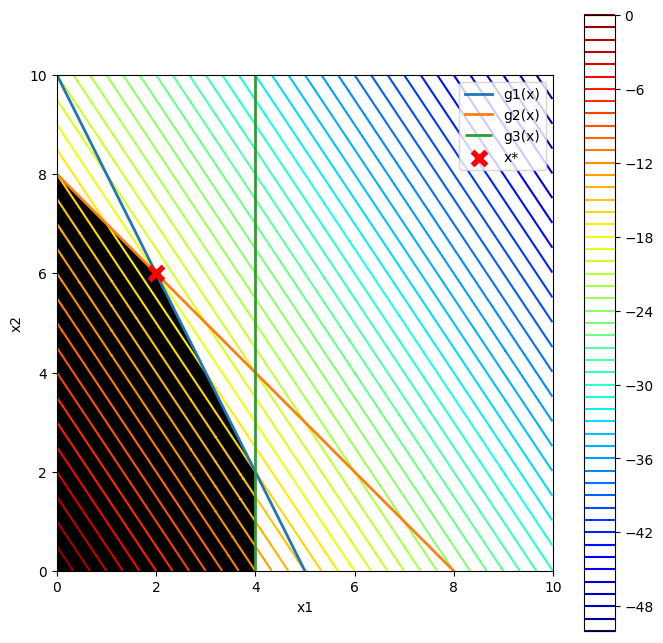

In [35]:
# create a contour plot with 50 levels and jet color scheme
plt.figure(figsize=(8, 8))
plt.contour(x1, x2, results, 50, alpha=1.0, cmap=plt.cm.jet)
plt.xlabel('x1')
plt.ylabel('x2')
plt.colorbar()

# get list of python colors
colors = list(plt.rcParams['axes.prop_cycle'].by_key()['color'])

# plot the constraints
plot_constraints(A, b_ub, colors[:len(A)])

# plot the feasible region
region = compute_region(A, b_ub, x1, x2)
plt.imshow(region, extent=(x1.min(), x1.max(), x2.min(), x2.max()), 
           origin="lower", cmap="Greys", alpha = 1, zorder=0)

# plot the results
plt.scatter(res.x[0], res.x[1], color='red', zorder=3, label='x*', marker='x', s=100, linewidth=4)

# limit the plot to the range
plt.xlim(r_min, r_max)
plt.ylim(r_min, r_max)
plt.legend()
plt.show()

### Problem 2

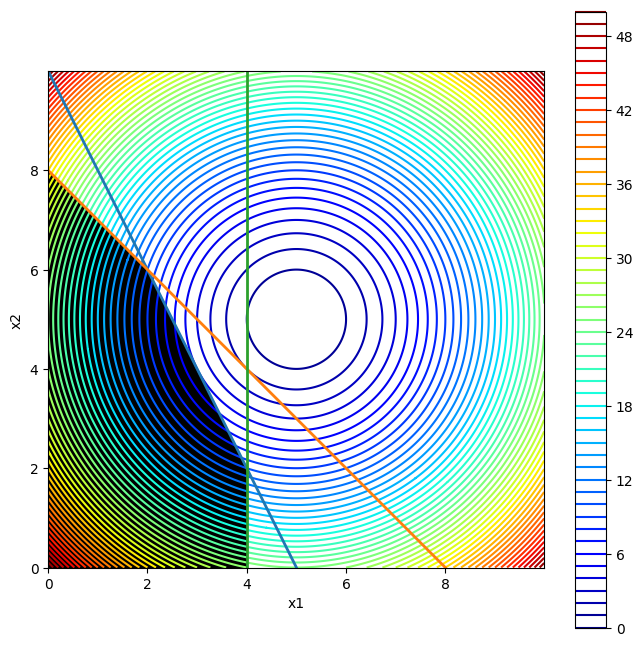

In [36]:
c = [1, 1, -10, -10, 50]

# new objective function
def objective(x, c):
    return c[0]*x[0]**2 + c[1]*x[1]**2 + c[2]*x[0] + c[3]*x[1] + c[4]

# compute targets
results = objective(x, c)

# new contour plot
plt.figure(figsize=(8, 8))
plt.contour(x1, x2, results, 50, alpha=1.0, cmap=plt.cm.jet)
plt.xlabel('x1')
plt.ylabel('x2')
plt.colorbar()

# plot the constraints
plot_constraints(A, b_ub, colors[:len(A)])

# plot the feasible region
region = compute_region(A, b_ub, x1, x2)
plt.imshow(region, extent=(x1.min(), x1.max(), x2.min(), x2.max()), 
           origin="lower", cmap="Greys", alpha = 1, zorder=0)
plt.show()